# FIRE DEPARTMENT IDAR-OBERSTEIN MISSIONS

What a beautiflul little webscraping target right?!
Lets get the data and see if there is any seasonal dependence in the missions.

![Scraping Target](assets/target.png)

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
from tqdm.notebook import tqdm

URL = "https://feuerwehr-idar-oberstein.de/einsaetze/archiv"

### Webscraping

In [2]:
soup = BeautifulSoup(requests.get(URL).text, "html.parser")
years = [tag.text for tag in soup.select("#navigation a")]
years

['2020',
 '2019',
 '2018',
 '2017',
 '2016',
 '2015',
 '2014',
 '2013',
 '2012',
 '2011',
 '2010',
 '2009',
 '2008',
 '2007',
 '2006',
 '2005',
 '2004',
 '2003',
 '2002']

In [3]:
missions = []
for year in tqdm(years):
    url = f"{URL}/{year}"
    soup = BeautifulSoup(requests.get(url).text, "html.parser")
    rows = soup.select("table.contenttable tbody td")
    for i in range(0, len(rows), 6):
        row = {
            "number": rows[i+1].text,
            "date": rows[i+2].text,
            "time": rows[i+3].text,
            "location": rows[i+4].text,
            "description": rows[i+5].text
            
        }
        missions.append(row)

### Preprocessing

In [4]:
df = pd.DataFrame(missions)
df["datetime"] = pd.to_datetime(df["date"] + " " + df["time"], errors="coerce")
df = df.set_index("datetime")
df = df.drop(["date", "time"], axis=1)
df = df.loc[df.index.notnull()]
df = df.sort_index()
df

,number,location,description
datetime,,,
2002-01-01 13:20:00,001,Lichtenfelder Straße,PKW Brand
2002-01-03 19:03:00,028,Zwischen Wasser,Ausleuchten einer Einsatzstelle
2002-01-04 13:25:00,040,Nahbollenbacher Straße,Parkplatz-Dieselauslauf
2002-01-05 21:26:00,049,B 270 oberhalb Niederreidenbacher Hof,Ausleuchten einer Einsatzstelle
2002-01-06 14:56:00,061,Mittelbollenbacher Straße,Waldbrand
...,...,...,...
2020-10-02 12:16:00,024,Jahnstraße,Umgestürtzter Baum auf Gebäude
2020-11-01 03:36:00,006,Am roten Baum,Unterstützung Rettungsdienst mit Drehleiter
2020-11-03 06:57:00,076,Heinzenwies,Rauchmelder Alarm


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3055 entries, 2002-01-01 13:20:00 to 2020-12-02 16:14:00
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   number       3055 non-null   object
 1   location     3055 non-null   object
 2   description  3055 non-null   object
dtypes: object(3)
memory usage: 95.5+ KB


### What is the first and last mission in the dataset?

In [6]:
df.tail(1), df.head(1)

(                    number        location description
 datetime                                              
 2020-12-02 16:14:00    025  Unterer Staden  Kaminbrand,
                     number              location description
 datetime                                                    
 2002-01-01 13:20:00    001  Lichtenfelder Straße   PKW Brand)

### Missions (Minute, Hour)

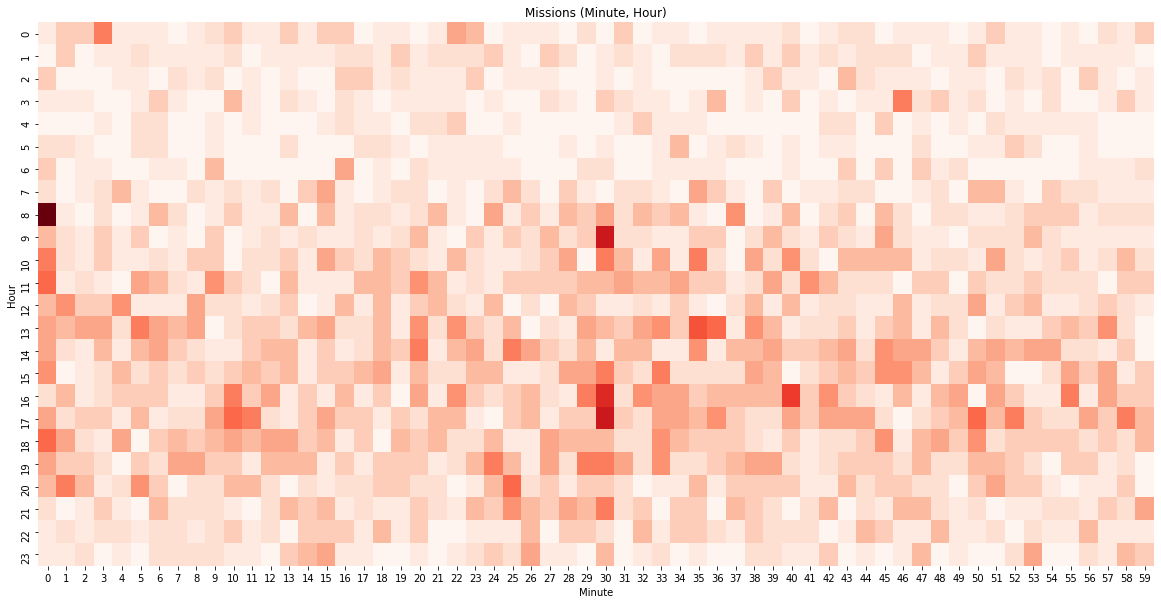

In [7]:
heat = df.groupby([df.index.hour, df.index.minute]).count()["number"].unstack().fillna(0).to_numpy()

plt.figure(figsize=(20, 10))
ax = sns.heatmap(heat, cbar=False, cmap="Reds")
ax.set_title("Missions (Minute, Hour)")
ax.set_xlabel("Minute")
ax.set_ylabel("Hour")
ax

### Missions (Hour, Weekday)

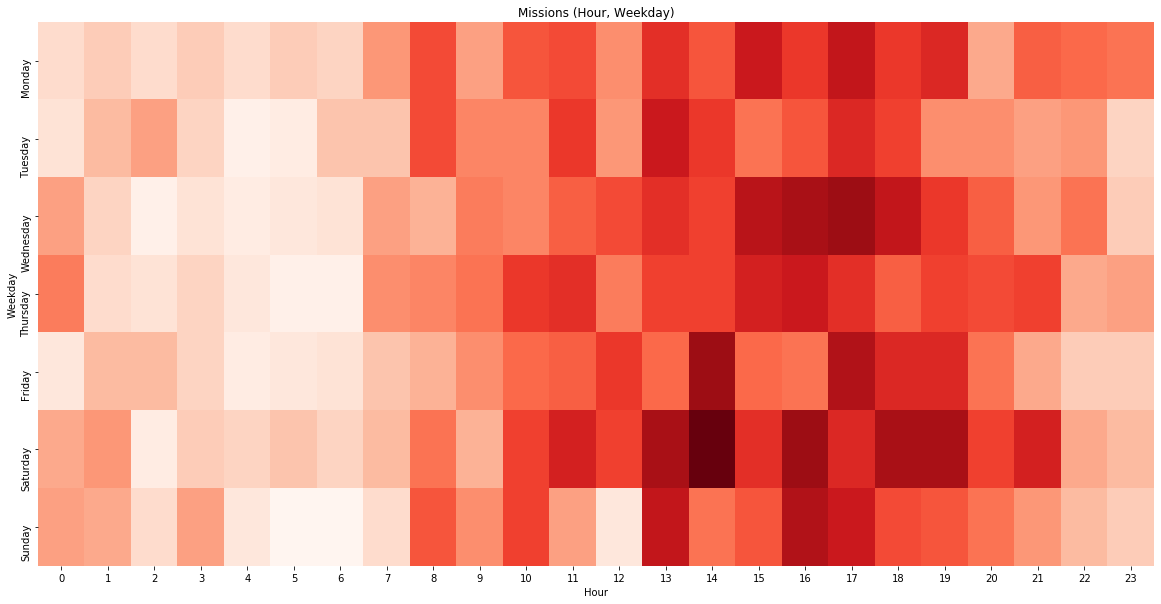

In [8]:
heat = df.groupby([df.index.weekday, df.index.hour]).count()["number"].unstack().fillna(0).to_numpy()

plt.figure(figsize=(20, 10))
ax = sns.heatmap(heat, cbar=False, cmap="Reds", yticklabels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
ax.set_title("Missions (Hour, Weekday)")
ax.set_xlabel("Hour")
ax.set_ylabel("Weekday")
ax

### Seasonal Monthly

Text(0, 0.5, 'Missions')

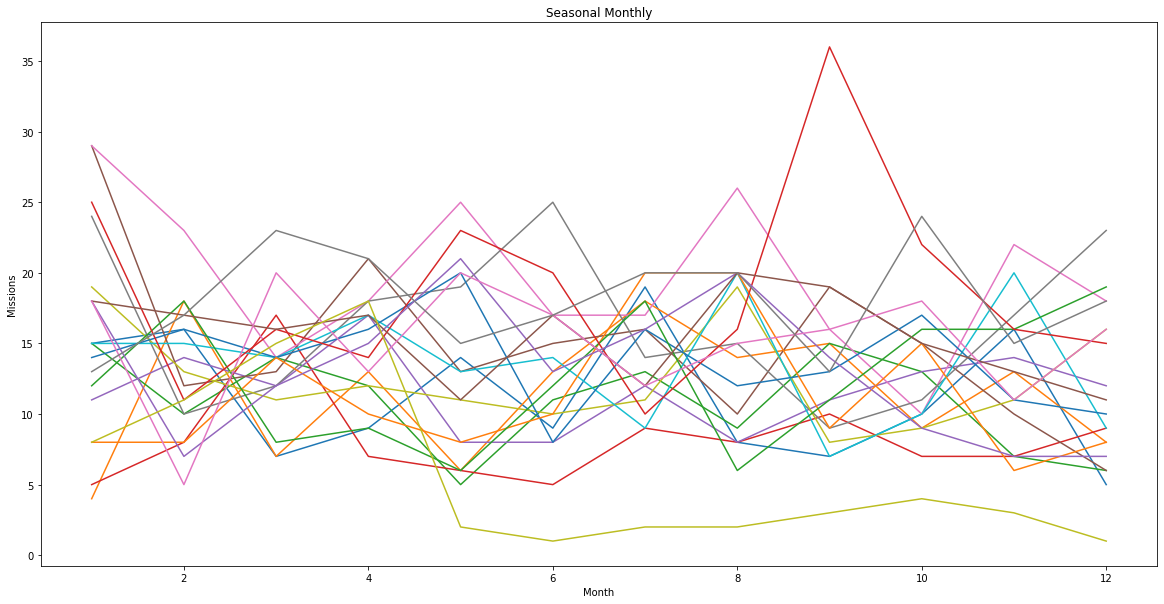

In [9]:
df.index = df.index.to_period("M")
seasonal = df.groupby(df.index).count()

monthly = pd.pivot_table(seasonal, index=seasonal.index.month, columns=seasonal.index.year, values="number")
ax = monthly.plot(figsize=(20, 10), legend=False, title="Seasonal Monthly")
ax.set_xlabel("Month")
ax.set_ylabel("Missions")